Name: Tien-Ching Hsieh  
Github Username: hsieh2000  
USC ID: 2642366337  

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,  GridSearchCV, KFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import euclidean
from collections import  Counter
from scipy.special import softmax
from scipy.stats import mode

import warnings
warnings.filterwarnings("ignore")



# 1.
## (a)

In [2]:
feature_cols = [f'Feature_{i}' for i in range(1, 31)]

In [3]:
df = pd.read_csv('../data/wdbc.data',
encoding='utf-8', 
header=None, 
sep=',', 
names=['ID', 'Diagnosis'] + feature_cols)

In [4]:
df

,ID,Diagnosis,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## (b)  
### i.

In [5]:
def preprocess(df_pos, df_neg, test_size, random):
    df_pos_train, df_pos_test = train_test_split(df_pos, test_size=test_size, random_state=random)
    df_neg_train, df_neg_test = train_test_split(df_neg, test_size=test_size, random_state=random)

    # Combine
    df_train = pd.concat([df_pos_train, df_neg_train])
    df_test = pd.concat([df_pos_test, df_neg_test])

    X_train, X_test = df_train.iloc[:, 2:], df_test.iloc[:, 2:]
    y_train, y_test = df_train.iloc[:, 1].apply(lambda x: 1 if x=="M" else -1).to_numpy(), df_test.iloc[:, 1].apply(lambda x: 1 if x=="M" else -1).to_numpy()
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def ROC_plot(fpr, tpr, auc, dataset="Training"):
    plt.plot(fpr, tpr, color='red', label=f'ROC curve:\nAUC = {auc}')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="best")
    plt.title(f'{dataset} ROC Curve')
    plt.show()


def report(_X, _y, model, report_lst: list, dataset: str="Training", plot: bool=False, unsupervised: str = None, unsupervised_test_set: bool = False, _y_majority_poll: list = None, positive_cluster_idx: int = None):
    # unsupervised_paras:
    #   unsupervised: the name of the unsupervised model
    #   unsupervised_dataset: if current dataset is test set
    #   _y_majority_poll: list of labels decided by the majority poll
    #   positive_cluster_idx: the index of positive label (y == 1)

    if unsupervised:
        if unsupervised == 'KMeans':
            if unsupervised_test_set:
                _y_pred = model.predict(_X)
                if positive_cluster_idx == 0:
                    _y_pred = list(map(lambda x: 1 if x == 0 else -1, _y_pred))
                else:
                    _y_pred = list(map(lambda x: 1 if x == 1 else -1, _y_pred))

            else:
                _y_pred = _y_majority_poll 
                
            report = classification_report(_y, _y_pred, output_dict=True, zero_division=0) #
            distances = model.transform(_X)
            _y_proba = softmax(-distances, axis=1) #pseudo_probability
            fpr, tpr, thresholds = roc_curve(_y, _y_proba[:, positive_cluster_idx])

    else:
        _y_pred = model.predict(_X)
        report = classification_report(_y, _y_pred, output_dict=True, zero_division=0) #
        scores = model.decision_function(_X)
        # _y_proba = model.predict_proba(_X)

        # print(f'{dataset} Classification Report:\n{report}')
        # print(model.classes_)
        # print(y_proba)
        # fpr, tpr, thresholds = roc_curve(_y, _y_proba[:, 1])
        fpr, tpr, thresholds = roc_curve(_y, scores)

    roc_auc = auc(fpr, tpr)

    if plot:
        ROC_plot(fpr, tpr, roc_auc, dataset)
        print(f"{dataset} Confusion Matrix")
        print(confusion_matrix(_y, _y_pred))

    _dict = {}
    for i, k in enumerate(report['1'].keys()):
        if i != len(report['1'])-1: 
            _dict.update({f'avg {k}': (report['1'][k]+report['-1'][k])/2})
    _dict.update({'accuracy': report['accuracy'], 'AUC': float(roc_auc)})
    report_lst.append(_dict)

    return report_lst

def report_result(train_lst, test_lst, model_name, df_output):
    _df_output = df_output.copy()

    _df1 = pd.DataFrame(pd.DataFrame(train_lst).describe().iloc[1,:])
    _df1.rename(columns = {'mean':f'({model_name}) Training'}, inplace = True)

    _df2 = pd.DataFrame(pd.DataFrame(test_lst).describe().iloc[1,:])
    _df2.rename(columns = {'mean':f'({model_name}) Testing'}, inplace = True)  

    _df = pd.concat((_df1, _df2), axis=1).T

    return pd.concat((_df_output, _df), axis=0)


In [6]:
# Split by class
df_pos = df[df['Diagnosis'] == "M"]
df_neg = df[df['Diagnosis'] == "B"]

param_grid = {
    'C': [ 0.01, 0.1, 1, 10, 100, 1000],
}
# k_fold = KFold(n_splits=5, shuffle = True, random_state=42)
# model = SVC(kernel='linear', probability=True, random_state = 42)

M=1	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=0)
M=2	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=1)
M=3	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=2)
M=4	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=3)
M=5	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=4)
M=6	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=5)
M=7	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=6)
M=8	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=7)
M=9	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=8)
M=10	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=9)
M=11	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=10)
M=12	best mod

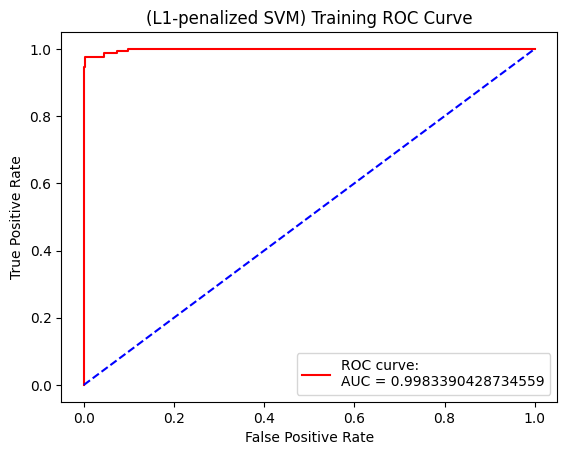

(L1-penalized SVM) Training Confusion Matrix
[[284   1]
 [  4 165]]


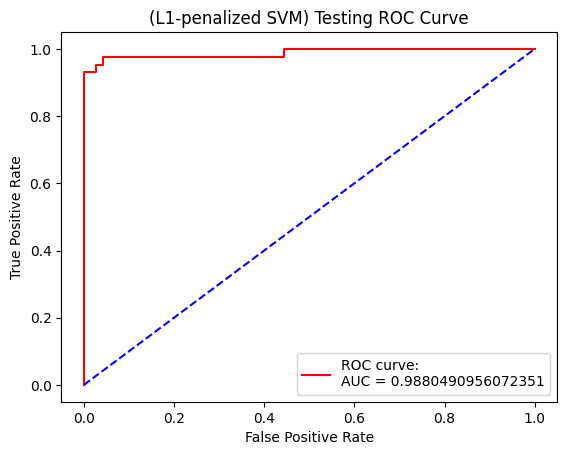

(L1-penalized SVM) Testing Confusion Matrix
[[70  2]
 [ 3 40]]


In [7]:
train_report_lst, test_report_lst = [], []
iteration = 30
for i in range(iteration):
    X_train, X_test, y_train, y_test = preprocess(df_pos, df_neg, 0.2, i)
    
    k_fold = KFold(n_splits=5, shuffle = True, random_state=i)
    model = LinearSVC(penalty='l1', dual=False, random_state = i, max_iter=1500)
    # model = SVC(kernel='linear', probability=True, random_state = i)
    gridcv = GridSearchCV(model, param_grid, cv=k_fold, refit=True)
    gridcv.fit(X_train, y_train)
    print(f'M={i+1}\tbest model: {gridcv.best_estimator_}')

    if i != iteration-1:
        train_report_lst = report(X_train, y_train, gridcv, train_report_lst, dataset="(L1-penalized SVM) Training", plot=False)
        test_report_lst = report(X_test, y_test, gridcv, test_report_lst, dataset="(L1-penalized SVM) Testing", plot=False)
    else:
        print(f'ROC at M = {i+1}')
        train_report_lst = report(X_train, y_train, gridcv, train_report_lst, dataset="(L1-penalized SVM) Training", plot=True)
        test_report_lst = report(X_test, y_test, gridcv, test_report_lst, dataset="(L1-penalized SVM) Testing", plot=True)

In [8]:
df_summary = pd.DataFrame()
df_summary = report_result(train_report_lst, test_report_lst, 'L1-penalized SVM', df_summary)
df_summary

,avg precision,avg recall,avg f1-score,accuracy,AUC
(L1-penalized SVM) Training,0.986924,0.982773,0.984774,0.985830,0.997316
(L1-penalized SVM) Testing,0.975612,0.969719,0.972184,0.974203,0.993928


### ii.


In [9]:
def find_farest_point_idx(decision_score):
    abs_decision_score = list(map(lambda x: abs(x), decision_score))
    farest_idx = np.argmax(abs_decision_score)
    return farest_idx

    

M=1	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=0)
M=2	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=1)
M=3	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=2)
M=4	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=3)
M=5	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=4)
M=6	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=5)
M=7	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=6)
M=8	best model: LinearSVC(C=1000, dual=False, max_iter=1500, penalty='l1', random_state=7)
M=9	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=8)
M=10	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=9)
M=11	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=10)
M=12	best 

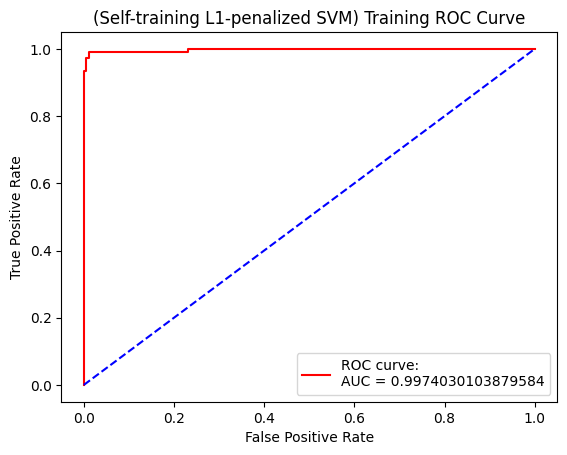

(Self-training L1-penalized SVM) Training Confusion Matrix
[[175   3]
 [  1 105]]


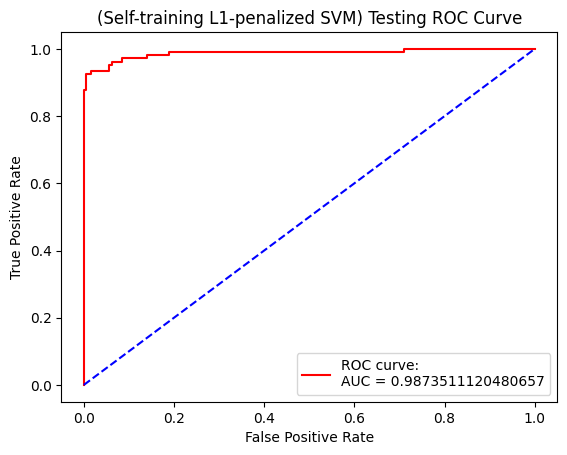

(Self-training L1-penalized SVM) Testing Confusion Matrix
[[165  14]
 [  4 102]]


In [10]:
train_report_lst, test_report_lst = [], []
iteration = 30
for i in range(iteration):
    random.seed(i)

    X_train, X_test, y_train, y_test = preprocess(df_pos, df_neg, 0.5, i)
    labeled_idx = random.sample(range(0, X_train.shape[0]), int(X_train.shape[0]/2))
    unlabeled_idx = list(set(range(X_train.shape[0])) - set(labeled_idx))

    X_train_labeled, y_train_labeled = X_train[labeled_idx], y_train[labeled_idx]
    X_train_unlabeled, y_train_unlabeled = X_train[unlabeled_idx], y_train[unlabeled_idx]

    k_fold = KFold(n_splits=5, shuffle = True, random_state=i)
    model = LinearSVC(penalty='l1', dual=False, random_state = i, max_iter=1500)
    # model = SVC(kernel='linear', probability=True, random_state = i)
    gridcv = GridSearchCV(model, param_grid, cv=k_fold, refit=True)
    gridcv.fit(X_train_labeled, y_train_labeled)
    print(f'M={i+1}\tbest model: {gridcv.best_estimator_}')

    # print(gridcv.best_estimator_.support_vectors_.shape)
    model = LinearSVC(penalty='l1', C=gridcv.best_estimator_.C, dual=False, random_state = i, max_iter=1500)
    # model = SVC(kernel='linear', C=gridcv.best_estimator_.C, probability=True, random_state = i)
    num = X_train_unlabeled.shape[0]
    for j in range(num):
        decision_score = gridcv.decision_function(X_train_unlabeled)
        farest_point_idx = find_farest_point_idx(decision_score)
        farest_point = X_train_unlabeled[farest_point_idx]
        predicted_label = gridcv.predict([farest_point])
        
        X_train_labeled, y_train_labeled = np.concatenate([X_train_labeled, [farest_point]]), np.concatenate([y_train_labeled, predicted_label])
        X_train_unlabeled = np.delete(X_train_unlabeled, farest_point_idx, axis=0)
        model.fit(X_train_labeled, y_train_labeled)

    if i != iteration-1:
        train_report_lst = report(X_train, y_train, model, train_report_lst, dataset="(Self-training L1-penalized SVM) Training", plot=False)
        test_report_lst = report(X_test, y_test, model, test_report_lst, dataset="(Self-training L1-penalized SVM) Testing", plot=False)
    else:
        print(f'ROC at M = {i+1}')
        train_report_lst = report(X_train, y_train, model, train_report_lst, dataset="(Self-training L1-penalized SVM) Training", plot=True)
        test_report_lst = report(X_test, y_test, model, test_report_lst, dataset="(Self-training L1-penalized SVM) Testing", plot=True)

In [11]:
df_summary = report_result(train_report_lst, test_report_lst, 'Self-training L1-penalized SVM', df_summary)
df_summary

,avg precision,avg recall,avg f1-score,accuracy,AUC
(L1-penalized SVM) Training,0.986924,0.982773,0.984774,0.985830,0.997316
(L1-penalized SVM) Testing,0.975612,0.969719,0.972184,0.974203,0.993928
(Self-training L1-penalized SVM) Training,0.978068,0.972430,0.974995,0.976761,0.994707
(Self-training L1-penalized SVM) Testing,0.961187,0.957306,0.958927,0.961754,0.990589


### iii.
We can use parameter 'n_init' to determine the times the k-means algorithm is run with different centroid seeds.
The final results is the best output of n_init consecutive runs in terms of inertia.
Higher 'n_init' can effectively avoid the change of trapping in local minimum.

ROC at M = 30


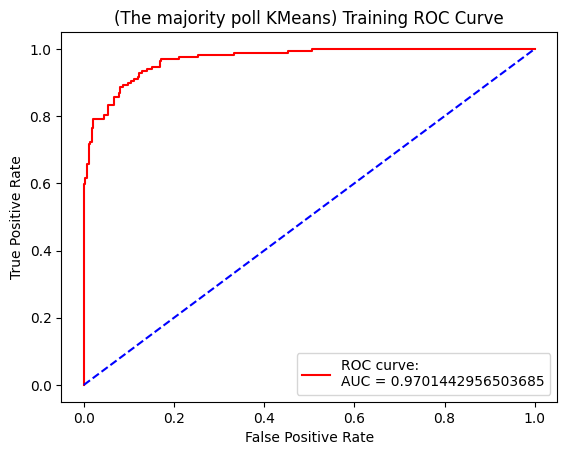

(The majority poll KMeans) Training Confusion Matrix
[[271  14]
 [ 33 136]]


In [12]:
train_report_lst, test_report_lst = [], []
iteration = 30

for i in range(iteration):
    X_train, X_test, y_train, y_test = preprocess(df_pos, df_neg, 0.2, i)

    model = KMeans(n_clusters=2, init='random', n_init=10, random_state = i)
    model.fit_predict(X_train)

    C0_index = [idx for idx, val in enumerate(model.labels_) if val == 0]
    C1_index = list(set(range(len(model.labels_))) - set(C0_index))

    C0_distance, C1_distance = [(k, euclidean(P, model.cluster_centers_[0])) for k, P in enumerate(X_train[C0_index])], [(k, euclidean(P, model.cluster_centers_[1])) for k, P in enumerate(X_train[C1_index])]
    C0_top30_idx, C1_top30_idx = list(map(lambda x: x[0], sorted(C0_distance, key=lambda x: x[1], reverse=False)[:30])), list(map(lambda x: x[0], sorted(C1_distance, key=lambda x: x[1], reverse=False)[:30]))
    C0_value, C1_value = int(Counter(y_train[C0_index][C0_top30_idx]).most_common(1)[0][0]), int(Counter(y_train[C1_index][C1_top30_idx]).most_common(1)[0][0])

    y_train_majority_poll = [C0_value if idx in C0_index else C1_value for idx in range(y_train.shape[0])]
    # decide which cluster is the positive
    positive_cluster_idx = 0 if C0_value == 1 else 1

    if i != iteration-1:
        train_report_lst = report(X_train, y_train, model, train_report_lst, dataset="(The majority poll KMeans) Training", plot=False, unsupervised = 'KMeans', unsupervised_test_set = False, _y_majority_poll = y_train_majority_poll, positive_cluster_idx = positive_cluster_idx)
        test_report_lst = report(X_test, y_test, model, test_report_lst, dataset="(The majority poll KMeans) Testing", plot=False, unsupervised = 'KMeans', unsupervised_test_set = True, positive_cluster_idx = positive_cluster_idx)

    else:
        print(f'ROC at M = {i+1}')
        train_report_lst = report(X_train, y_train, model, train_report_lst, dataset="(The majority poll KMeans) Training", plot=True, unsupervised = 'KMeans', unsupervised_test_set = False, _y_majority_poll = y_train_majority_poll, positive_cluster_idx = positive_cluster_idx)
        test_report_lst = report(X_test, y_test, model, test_report_lst, dataset="(The majority poll KMeans) Testing", plot=False, unsupervised = 'KMeans', unsupervised_test_set = True, positive_cluster_idx = positive_cluster_idx)



In [13]:
df_summary = report_result(train_report_lst, test_report_lst, 'The majority poll KMeans', df_summary)
df_summary

,avg precision,avg recall,avg f1-score,accuracy,AUC
(L1-penalized SVM) Training,0.986924,0.982773,0.984774,0.985830,0.997316
(L1-penalized SVM) Testing,0.975612,0.969719,0.972184,0.974203,0.993928
(Self-training L1-penalized SVM) Training,0.978068,0.972430,0.974995,0.976761,0.994707
(Self-training L1-penalized SVM) Testing,0.961187,0.957306,0.958927,0.961754,0.990589
(The majority poll KMeans) Training,0.911472,0.891892,0.899920,0.908517,0.973348
(The majority poll KMeans) Testing,0.915082,0.896221,0.903715,0.911884,0.976647


### iv.

In [14]:
def compute_cluster_info(X_train, y_train, n_clusters=2, gamma=10e-4, random=42):
    model = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=gamma, random_state=random)
    labels = model.fit_predict(X_train)

    cluster_proba = {}
    cluster_centers = {}
    cluster_to_label = {}

    for cluster_id in range(n_clusters):
        indices = np.where(labels == cluster_id)[0]
        cluster_y = y_train[indices]
        pos_ratio = np.mean(cluster_y)
        majority_label = mode(cluster_y, keepdims=True).mode[0]

        cluster_proba[cluster_id] = pos_ratio
        cluster_centers[cluster_id] = np.mean(X_train[indices], axis=0)
        cluster_to_label[cluster_id] = majority_label

    return labels, cluster_proba, cluster_centers, cluster_to_label

def predict_with_cluster(X, y, cluster_labels, cluster_proba, cluster_centers, cluster_to_label, mode='train'):
    if mode == 'train':
        preds = np.array([cluster_to_label[cluster_labels[i]] for i in range(len(X))])
        scores = np.array([cluster_proba[cluster_labels[i]] for i in range(len(X))])
    else:
        preds = []
        scores = []
        for x in X:
            d0 = np.linalg.norm(x - cluster_centers[0])
            d1 = np.linalg.norm(x - cluster_centers[1])
            nearest_cluster = 0 if d0 < d1 else 1
            preds.append(cluster_to_label[nearest_cluster])
            scores.append(cluster_proba[nearest_cluster])
        preds = np.array(preds)
        scores = np.array(scores)

    report = classification_report(y, preds, output_dict=True, zero_division=0)
    fpr, tpr, thresholds = roc_curve(y, scores)
    auc_score = auc(fpr, tpr)
    conf_mat = confusion_matrix(y, preds)

    return report, auc_score, fpr, tpr, conf_mat


def extract_avg_metrics(report, auc_score):
    result = {}
    for j, k in enumerate(report['1'].keys()):
        if j != len(report['1']) - 1:
            result[f'avg {k}'] = (report['1'][k] + report['-1'][k]) / 2
    result['accuracy'] = report['accuracy']
    result['AUC'] = auc_score
    return result



ROC at M = 30


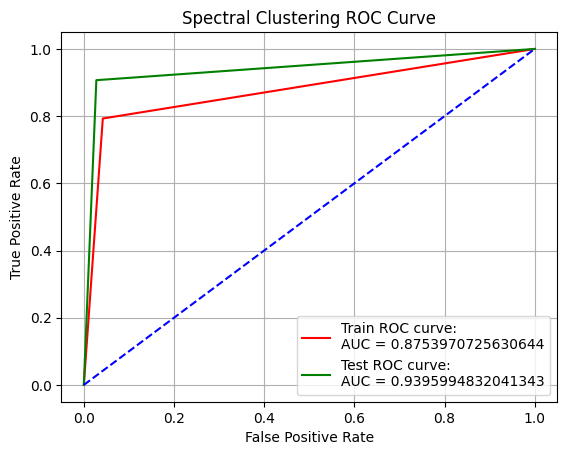

(Spectral Clustering) Training Confusion Matrix:
[[273  12]
 [ 35 134]]
(Spectral Clustering) Testing Confusion Matrix:
[[70  2]
 [ 4 39]]


In [15]:
train_report_lst, test_report_lst = [], []
iteration = 30

for i in range(iteration):
    X_train, X_test, y_train, y_test = preprocess(df_pos, df_neg, 0.2, i)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    cluster_labels, cluster_proba, cluster_centers, cluster_to_label = compute_cluster_info(X_train, y_train, random=i)

    train_report, train_auc, fpr, tpr, train_confmat = predict_with_cluster(
        X_train, y_train, cluster_labels, cluster_proba, cluster_centers, cluster_to_label, mode='train')
    train_report_lst.append(extract_avg_metrics(train_report, train_auc))

    test_report, test_auc, fpr_test, tpr_test, test_confmat = predict_with_cluster(
        X_test, y_test, cluster_labels, cluster_proba, cluster_centers, cluster_to_label, mode='test')
    test_report_lst.append(extract_avg_metrics(test_report, test_auc))

    if i == iteration - 1:
        print(f'ROC at M = {i+1}')
        plt.plot(fpr, tpr, label=f"Train ROC curve:\nAUC = {train_auc}", color='red')
        plt.plot(fpr_test, tpr_test, label=f"Test ROC curve:\nAUC = {test_auc}", color='green')
        plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Spectral Clustering ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"(Spectral Clustering) Training Confusion Matrix:\n{train_confmat}")
        print(f"(Spectral Clustering) Testing Confusion Matrix:\n{test_confmat}")


### v.
Yes, just like the statement in this problem, supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled. And unsupervised learning underperforms in such situations.

In [16]:
df_summary = report_result(train_report_lst, test_report_lst, 'Spectral Clustering', df_summary)
df_summary

,avg precision,avg recall,avg f1-score,accuracy,AUC
(L1-penalized SVM) Training,0.986924,0.982773,0.984774,0.985830,0.997316
(L1-penalized SVM) Testing,0.975612,0.969719,0.972184,0.974203,0.993928
(Self-training L1-penalized SVM) Training,0.978068,0.972430,0.974995,0.976761,0.994707
(Self-training L1-penalized SVM) Testing,0.961187,0.957306,0.958927,0.961754,0.990589
(The majority poll KMeans) Training,0.911472,0.891892,0.899920,0.908517,0.973348
(The majority poll KMeans) Testing,0.915082,0.896221,0.903715,0.911884,0.976647
(Spectral Clustering) Training,0.911859,0.890439,0.899133,0.908003,0.890439
(Spectral Clustering) Testing,0.914708,0.894358,0.902325,0.910725,0.894358


# 2
## (a)

In [17]:
with open('../data/data_banknote_authentication.txt') as f:
    rows = f.readlines()
    data = [r.split('\n')[0].split(',') for r in rows]
    df = pd.DataFrame(data)
    for i in [0, 1, 2, 3]:
        df[i] = df[i].astype(float)
    df[4] = df[4].astype(int)
    df.rename(columns={0:'x1', 1:'x2', 2:'x3', 3:'x4', 4:'y'}, inplace=True)
    
        

In [18]:
param_grid = {
    'C': [ 0.01, 0.1, 1, 10, 100, 1000],
}

In [19]:
def preprocess(df, n, random = 42):

    df_train, df_test = train_test_split(df, test_size=n, stratify=df['y'], shuffle=True,random_state = random)

    X_train, X_test = df_train.iloc[:, :-1], df_test.iloc[:, :-1]
    y_train, y_test = df_train.iloc[:, -1].to_numpy(), df_test.iloc[:, -1].to_numpy()

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def find_nearest_10_points_idx(decision_score, random_select = False):
    abs_decision_score = list(map(lambda x: abs(x), decision_score))
    nearest_idx_lst = np.argsort(abs_decision_score)[:10]
    if random_select == True:
        nearest_idx_lst = np.random.choice(np.argsort(abs_decision_score), size=10, replace=False, )
        
    return nearest_idx_lst

In [20]:
X_train, X_test, y_train, y_test = preprocess(df, 472)

## (b)
### i.

In [27]:
def passive(X_train, X_test, y_train, y_test, random_state = 1):
    passive_test_err_lst = []
    for i in range(10, 901, 10):
        k_fold = KFold(n_splits=5, shuffle = True, random_state= i * random_state)
        model = LinearSVC(penalty='l1', dual=False, random_state = i * random_state, max_iter=1500)
        # model = SVC(kernel='linear', probability=True, random_state = i * random_state)
        gridcv = GridSearchCV(model, param_grid, cv=k_fold, refit=True)
        gridcv.fit(X_train[:i], y_train[:i])
        y_pred = gridcv.predict(X_test)
        test_err = 1 - accuracy_score(y_test, y_pred)
        passive_test_err_lst.append(test_err)
        if random_state == 1:
            print(f'Num of Data = {i}\tbest model: {gridcv.best_estimator_}')

    return passive_test_err_lst

passive(X_train, X_test, y_train, y_test)

Num of Data = 10	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=10)
Num of Data = 20	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=20)
Num of Data = 30	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=30)
Num of Data = 40	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=40)
Num of Data = 50	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=50)
Num of Data = 60	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=60)
Num of Data = 70	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=70)
Num of Data = 80	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=80)
Num of Data = 90	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=90)
Num of Data = 100	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, 

[0.05084745762711862,
 0.03177966101694918,
 0.029661016949152574,
 0.03389830508474578,
 0.03389830508474578,
 0.03389830508474578,
 0.03813559322033899,
 0.03813559322033899,
 0.03813559322033899,
 0.03813559322033899,
 0.03813559322033899,
 0.03813559322033899,
 0.03813559322033899,
 0.03601694915254239,
 0.03601694915254239,
 0.021186440677966156,
 0.021186440677966156,
 0.021186440677966156,
 0.03601694915254239,
 0.03601694915254239,
 0.014830508474576232,
 0.021186440677966156,
 0.03601694915254239,
 0.008474576271186418,
 0.03177966101694918,
 0.03177966101694918,
 0.01906779661016944,
 0.014830508474576232,
 0.012711864406779627,
 0.012711864406779627,
 0.012711864406779627,
 0.016949152542372836,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.00847

### ii.

In [28]:
def active(X_train, X_test, y_train, y_test, random_state = 1):

    active_test_err_lst = []

    init_X_train, init_y_train = X_train[:10], X_train[:10]
    _X_train, _y_train =  X_train[10:], y_train[10:]
    i = 0
    while i<= 900:
        i += 10
        k_fold = KFold(n_splits=5, shuffle = True, random_state=i * random_state)
        # model = SVC(kernel='linear', probability=True, random_state = i * random_state)
        model = LinearSVC(penalty='l1', dual=False, random_state = i * random_state, max_iter=1500)
        gridcv = GridSearchCV(model, param_grid, cv=k_fold, refit=True)
        if i == 10:
            new_X, new_y = X_train[:10], y_train[:10]

        gridcv.fit(new_X, new_y)
        if random_state == 1:
            print(f'Num of Data = {i}\tbest model: {gridcv.best_estimator_}')

        y_pred = gridcv.predict(X_test)
        test_err = 1 - accuracy_score(y_test, y_pred)
        active_test_err_lst.append(test_err)

        if _X_train.shape[0] == 0:
            break

        decision_score = gridcv.decision_function(_X_train)
        nearest_idx_lst = find_nearest_10_points_idx(decision_score)
        np.random.seed(i)
        while len(set(_y_train[nearest_idx_lst])) < 2:
            nearest_idx_lst = find_nearest_10_points_idx(decision_score, random_select=True)
            if np.unique(_y_train, return_counts=True)[0].shape[0] < 2:
                # print(np.unique(_y_train, return_counts=True))
                break

        new_X, new_y = np.concatenate((new_X, _X_train[nearest_idx_lst]), axis = 0), np.concatenate((new_y, _y_train[nearest_idx_lst]), axis = 0)
        _X_train, _y_train = np.delete(_X_train, nearest_idx_lst, axis=0), np.delete(_y_train, nearest_idx_lst)
    
    return active_test_err_lst

active(X_train, X_test, y_train, y_test)

Num of Data = 10	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=10)
Num of Data = 20	best model: LinearSVC(C=1000, dual=False, max_iter=1500, penalty='l1', random_state=20)
Num of Data = 30	best model: LinearSVC(C=10, dual=False, max_iter=1500, penalty='l1', random_state=30)
Num of Data = 40	best model: LinearSVC(C=10, dual=False, max_iter=1500, penalty='l1', random_state=40)
Num of Data = 50	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=50)
Num of Data = 60	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=60)
Num of Data = 70	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=70)
Num of Data = 80	best model: LinearSVC(C=10, dual=False, max_iter=1500, penalty='l1', random_state=80)
Num of Data = 90	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=90)
Num of Data = 100	best model: LinearSVC(C=10, dual=False, max_iter=1500, pen

[0.05084745762711862,
 0.048728813559322015,
 0.021186440677966156,
 0.012711864406779627,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.012711864406779627,
 0.008474576271186418,
 0.012711864406779627,
 0.008474576271186418,
 0.012711864406779627,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.012711864406779627,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.012711864406779627,
 0.012711864406779627,
 0.008474576271186418,
 0.012711864406779627,
 0.008474576271186418,
 0.012711864406779627,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576271186418,
 0.008474576

## (c)

In [29]:
result_dict = {
    'passive': [],
    'active': []
}

for r in range(50):
    print(f'iter: {r+1}')
    X_train, X_test, y_train, y_test = preprocess(df, 472)
    passive_err = passive(X_train, X_test, y_train, y_test, random_state=r)
    active_err = active(X_train, X_test, y_train, y_test, random_state=r)
    result_dict['passive'].append(passive_err)
    result_dict['active'].append(active_err)

iter: 1
iter: 2
Num of Data = 10	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=10)
Num of Data = 20	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=20)
Num of Data = 30	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=30)
Num of Data = 40	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=40)
Num of Data = 50	best model: LinearSVC(C=1, dual=False, max_iter=1500, penalty='l1', random_state=50)
Num of Data = 60	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=60)
Num of Data = 70	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=70)
Num of Data = 80	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=80)
Num of Data = 90	best model: LinearSVC(C=0.1, dual=False, max_iter=1500, penalty='l1', random_state=90)
Num of Data = 100	best model: LinearSVC(C=0.1, dual=False,

In [30]:
result_dict

{'passive': [[0.05084745762711862,
   0.03177966101694918,
   0.029661016949152574,
   0.03389830508474578,
   0.03389830508474578,
   0.03389830508474578,
   0.03813559322033899,
   0.03813559322033899,
   0.03813559322033899,
   0.03813559322033899,
   0.03813559322033899,
   0.03813559322033899,
   0.03813559322033899,
   0.03601694915254239,
   0.03601694915254239,
   0.021186440677966156,
   0.021186440677966156,
   0.021186440677966156,
   0.03601694915254239,
   0.021186440677966156,
   0.021186440677966156,
   0.03601694915254239,
   0.03601694915254239,
   0.008474576271186418,
   0.03177966101694918,
   0.03177966101694918,
   0.014830508474576232,
   0.008474576271186418,
   0.012711864406779627,
   0.012711864406779627,
   0.012711864406779627,
   0.016949152542372836,
   0.008474576271186418,
   0.008474576271186418,
   0.008474576271186418,
   0.008474576271186418,
   0.008474576271186418,
   0.008474576271186418,
   0.008474576271186418,
   0.008474576271186418,
   0.008

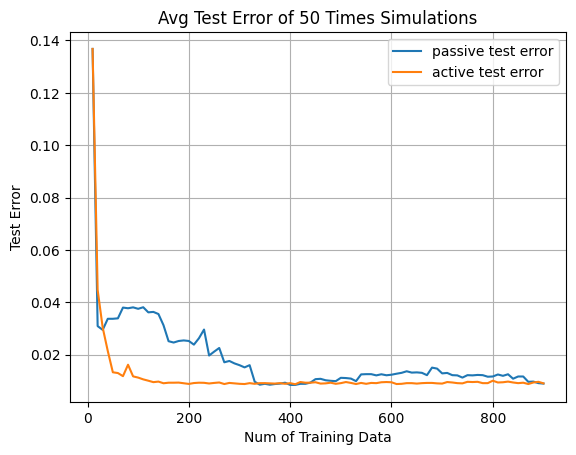

In [ ]:
for k, v in result_dict.items():
    avg_50_err = np.mean(v, axis=0)
    plt.plot(range(10, 901, 10), avg_50_err, label=f"{k} test error")
plt.xlabel("Num of Training Data")
plt.ylabel("Test Error")
plt.title("Avg Test Error of 50 Times Simulations")
plt.legend()
plt.grid(True)
plt.show()
